In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# Mã hóa nhị phân cho kết nối trong mạng


*   Chuỗi nhị phân 20 bits.
*   Mạng gồm 2 blocks, mỗi block giải mã thành 5 nút từ chuỗi nhị phân dài 10 bits.




In [12]:
class CustomNode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomNode, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CustomBlock(nn.Module):
    def __init__(self, encoding, in_channels, out_channels):
        super(CustomBlock, self).__init__()

        # Nút 0: nút mặc định
        self.default_initial_node = CustomNode(in_channels, out_channels)

        # Giải mã
        self.node_encodings = []
        idx = 0
        k = 1  # Start with the 1st bit for node 2
        while idx < len(encoding):
            self.node_encodings.append(encoding[idx:idx+k])
            idx += k
            k += 1

        # Thêm nút 1 không nằm trong mã hóa
        self.layers = nn.ModuleList([CustomNode(out_channels, out_channels) for _ in range(len(self.node_encodings) + 1)])

    def forward(self, x):
        outputs = [self.default_initial_node(x)]

        # Xử lý nút 1
        outputs.append(self.layers[0](outputs[0]))

        for idx, layer in enumerate(self.layers[1:], start=1):
            # Lấy đầu vào cho các nút dựa trên mã hóa
            node_inputs = [outputs[j] for j, val in enumerate(self.node_encodings[idx-1]) if val == '1']

            # Nếu không có đầu vào, lấy đầu vào là đầu ra nút mặc định (nút 0)
            if len(node_inputs) == 0:
                node_inputs.append(outputs[0])

            node_input = sum(node_inputs)
            node_output = layer(node_input)
            outputs.append(node_output)

        return outputs[-1]  # Trả về đầu ra của nút cuối cùng

class CustomCNN(nn.Module):
    def __init__(self, encoding):
        super(CustomCNN, self).__init__()

        encoding_length = len(encoding)
        half_encoding_length = encoding_length // 2

        self.block1 = CustomBlock(encoding[:half_encoding_length], in_channels=3, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2 = CustomBlock(encoding[half_encoding_length:], in_channels=64, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Lớp kết nối đầy đủ
        self.fc = nn.Linear(128 * 8 * 8, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Giải thuật NSGA2

In [13]:
class NSGA2:
    def __init__(self, pop_size, chrom_length, mutation_prob, crossover_prob, num_generations, model, train_loader, val_loader):
        self.pop_size = pop_size
        self.chrom_length = chrom_length
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.num_generations = num_generations
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.population = self.initialize_population()
        self.fitness_values = {}

    # Hàm khởi tạo quần thể
    def initialize_population(self):
        return np.random.randint(2, size=(self.pop_size, self.chrom_length))

    # Hàm đo độ trễ
    def measure_latency(self, model, device):
        model.eval()
        total_time = 0
        num_samples = 10  # Số lượng mẫu để đo độ trễ

        with torch.no_grad():
            for i in range(num_samples):
                data, _ = next(iter(self.val_loader))
                data = data.to(device)

                start_time = time.time()
                _ = model(data)
                end_time = time.time()

                total_time += (end_time - start_time)

        avg_latency = total_time / num_samples
        return avg_latency

    # Hàm tính toán lỗi trên tập kiểm chứng
    def evaluate_model_on_validation_set(self, model, val_loader, device):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        accuracy = correct / total
        error = 1 - accuracy
        return error

    # Hàm huấn luyện mô hình mạng
    def train_model(self, model, device, train_loader):
        optimizer = optim.Adam(model.parameters())
        for epoch in range(5):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = F.cross_entropy(output, target)
                loss.backward()
                optimizer.step()

    # Hàm đánh giá cá thể
    def evaluate_individual(self, individual):
        # Sử dụng chuỗi nhị phân làm khóa
        individual_key = tuple(individual)

        # Kiểm tra xem cá thể này đã được đánh giá trước đó chưa
        if individual_key not in self.fitness_values:
            # Biến đổi chuỗi nhị phân thành mô hình CustomCNN
            model = CustomCNN(individual)

            # Di chuyển mô hình sang thiết bị phù hợp (CPU hoặc GPU)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # Huấn luyện mô hình
            self.train_model(model, device, self.train_loader)

            # Đánh giá mô hình trên tập kiếm chứng
            error = self.evaluate_model_on_validation_set(model, self.val_loader, device)

            # Đo độ trễ
            latency = self.measure_latency(model, device)

            # Lưu trữ kết quả vào từ điển
            self.fitness_values[individual_key] = (latency, error)

        # Trả về kết quả đánh giá
        return self.fitness_values[individual_key]

    # Hàm sắp xếp không trội
    def non_dominated_sorting(self, population):
        population_size = len(self.population)
        front = [[]]
        rank = [0] * population_size
        count = [0] * population_size
        for p in range(population_size):
            S_p = []
            for q in range(population_size):
                if self.dominates(self.population[p], self.population[q]):
                    S_p.append(q)
                elif self.dominates(self.population[q], self.population[p]):
                    count[p] += 1
            if count[p] == 0:
                rank[p] = 0
                front[0].append(p)
        i = 0
        while front[i]:
            Q = []
            for p in front[i]:
                for q in S_p:
                    count[q] -= 1
                    if count[q] == 0:
                        rank[q] = i + 1
                        Q.append(q)
            i += 1
            front.append(Q)

        front.pop()
        return front

    # Hàm so sánh tính trội
    def dominates(self, individual1, individual2):
        # Lấy ra 2 thuộc tính
        latency1, error1 = self.fitness_values[tuple(individual1)]
        latency2, error2 = self.fitness_values[tuple(individual2)]

        # Kiểm tra tính trội
        return (latency1 <= latency2 and error1 <= error2) and (latency1 < latency2 or error1 < error2)

    # Hàm tính toán độ đông đúc
    def calculate_crowding_distance(self, front):
        distance = [0] * len(front)
        for m in range(2):
            # Sắp xếp theo từng thuộc tính
            front.sort(key=lambda x: self.fitness_values[tuple(self.population[x])][m])
            distance[0] = distance[-1] = float('inf')
            m_min = self.fitness_values[tuple(self.population[front[0]])][m]
            m_max = self.fitness_values[tuple(self.population[front[-1]])][m]
            for i in range(1, len(front) - 1):
                next_fitness = self.fitness_values[tuple(self.population[front[i + 1]])][m]
                prev_fitness = self.fitness_values[tuple(self.population[front[i - 1]])][m]
                distance[i] += (next_fitness - prev_fitness) / (m_max - m_min)
        return distance

    # Hàm chọn cha mẹ
    def select_parents(self):
        fronts = self.non_dominated_sorting(self.population)
        selected_parents = []
        for front in fronts:
            if len(selected_parents) + len(front) > self.pop_size:
                break
            for individual in front:
                selected_parents.append(self.population[individual])
        return selected_parents

    # Hàm lai ghép
    def crossover(self, parent1, parent2):
        child1, child2 = parent1.copy(), parent2.copy()
        cut_point1, cut_point2 = sorted(np.random.choice(range(1, self.chrom_length - 1), 2, replace=False))
        child1[cut_point1:cut_point2], child2[cut_point1:cut_point2] = child2[cut_point1:cut_point2], child1[cut_point1:cut_point2]
        return child1, child2


    # Hàm đột biến
    def mutate(self, individual):
        for i in range(self.chrom_length):
            if np.random.rand() < self.mutation_prob:
                individual[i] = 1 - individual[i]
        return individual

    # Hàm tạo thế hệ con
    def create_offspring(self, parents):
        offspring = []
        parent_indices = np.arange(len(parents))  # Tạo một mảng chỉ mục cho các cha mẹ

        for _ in range(self.pop_size // 2):
            if np.random.rand() < self.crossover_prob:
                # Chọn ngẫu nhiên chỉ mục của hai cha mẹ
                parent_idx1, parent_idx2 = np.random.choice(parent_indices, 2, replace=False)
                parent1, parent2 = parents[parent_idx1], parents[parent_idx2]

                child1, child2 = self.crossover(parent1, parent2)
                offspring.append(self.mutate(child1))
                offspring.append(self.mutate(child2))
            else:
                # Chọn ngẫu nhiên chỉ mục của hai cha mẹ mà không thực hiện crossover
                offspring_idx = np.random.choice(parent_indices, 2, replace=False)
                offspring.extend([parents[idx] for idx in offspring_idx])

        return offspring[:self.pop_size]

    def evolve(self):
        history = []  # Lưu giữ lịch sử của quần thể qua mỗi thế hệ

        for generation in range(self.num_generations):
            # Đánh giá quần thể
            for individual in self.population:
                self.evaluate_individual(individual)

            # Lưu kết quả đánh giá
            gen_data = [(self.fitness_values[tuple(individual)][0], self.fitness_values[tuple(individual)][1])
                        for individual in self.population]
            history.append(gen_data)

            # Chọn lọc cha mẹ
            parents = self.select_parents()

            # Tạo quần thể con
            offspring = self.create_offspring(parents)

            # Kết hợp quần thể hiện tại và quần thể con
            combined_population = self.population + offspring

            # Sắp xếp không trội và tính độ đông đúc trên quần thể kết hợp
            sorted_fronts = self.non_dominated_sorting(combined_population)
            crowding_distances = {}
            for front in sorted_fronts:
                distances = self.calculate_crowding_distance(front)
                for idx, individual_idx in enumerate(front):
                    crowding_distances[individual_idx] = distances[idx]

            # Chọn lọc quần thể mới
            new_population = []
            for front in sorted_fronts:
                if len(new_population) + len(front) <= self.pop_size:
                    new_population.extend(front)
                else:
                    # Sắp xếp các cá thể trong front này theo độ đông đúc giảm dần
                    front.sort(key=lambda idx: crowding_distances[idx], reverse=True)
                    new_population.extend(front[:self.pop_size - len(new_population)])
                    break

            # Cập nhật quần thể với các cá thể đã chọn
            self.population = [combined_population[idx] for idx in new_population]

        return history

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

nsga2 = NSGA2(pop_size=10, chrom_length=20, mutation_prob=0.1, crossover_prob=0.8, num_generations=200, model=CustomCNN, train_loader=trainloader, val_loader=testloader)
history = nsga2.evolve()

Files already downloaded and verified
Files already downloaded and verified


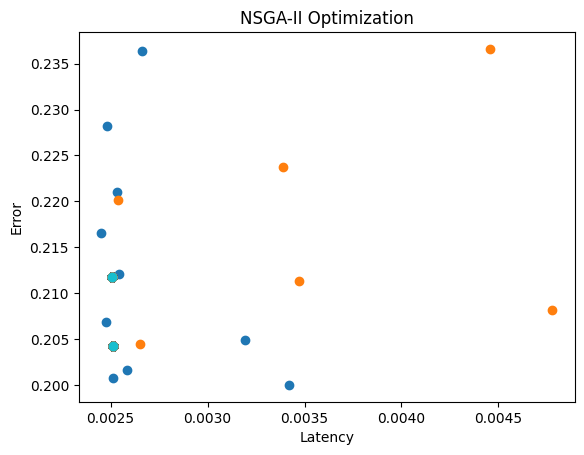

In [19]:
def plot_history(history):
    for gen, gen_data in enumerate(history):
        latencies, errors = zip(*gen_data)
        plt.scatter(latencies, errors, label=f'Generation {gen}')
    plt.xlabel('Latency')
    plt.ylabel('Error')
    plt.title('NSGA-II Optimization')
    plt.show()

# Sau khi quá trình tiến hóa kết thúc, vẽ đồ thị từ lịch sử:
plot_history(history)

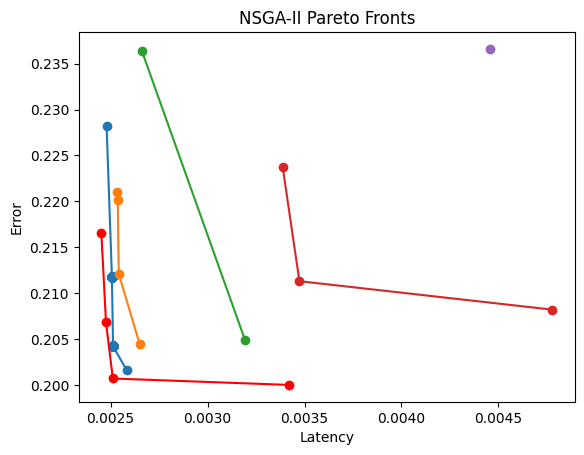

In [16]:
# Hàm kiểm tra xem một điểm có bị trội bởi một điểm khác không
def dominates(point, other):
    return (point[0] <= other[0] and point[1] < other[1]) or (point[0] < other[0] and point[1] <= other[1])

# Hàm tìm tất cả các Pareto fronts từ một tập hợp các điểm
def find_pareto_fronts(points):
    pareto_fronts = []
    points = points.copy()

    while points:
        non_dominated = []
        candidates = points.copy()
        for point in candidates:
            if not any(dominates(other, point) for other in candidates if other != point):
                non_dominated.append(point)
                points.remove(point)
        pareto_fronts.append(non_dominated)

    return pareto_fronts

# Hàm vẽ các Pareto fronts
def plot_pareto_fronts(history):
    all_points = [point for gen in history for point in gen]
    pareto_fronts = find_pareto_fronts(all_points)

    for i, front in enumerate(pareto_fronts):
        front = sorted(front, key=lambda x: x[0])  # Sắp xếp theo latency
        latencies, errors = zip(*front)
        color = 'red' if i == 0 else None  # Đặt màu cho front rank 0 là màu đỏ
        plt.scatter(latencies, errors, color=color)
        plt.plot(latencies, errors, color=color)

    plt.title('NSGA-II Pareto Fronts')
    plt.xlabel('Latency')
    plt.ylabel('Error')
    plt.show()

# Chạy hàm vẽ đồ thị với dữ liệu lịch sử
plot_pareto_fronts(history)

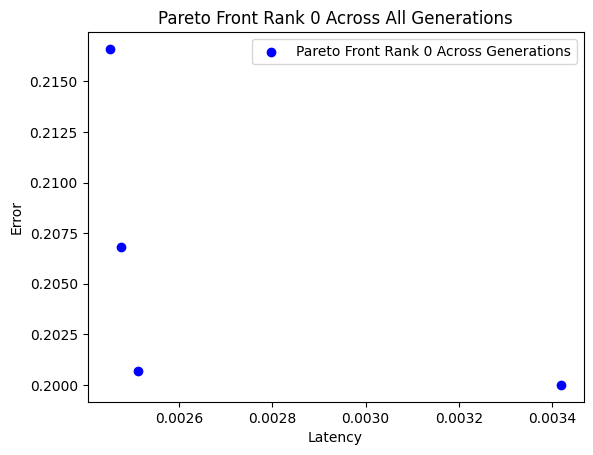

In [17]:
def is_dominated(point, others):
    for other in others:
        if (other[0] <= point[0] and other[1] < point[1]) or (other[0] < point[0] and other[1] <= point[1]):
            return True
    return False

def plot_pareto_front_over_generations(history):
    # Lấy tất cả các điểm từ tất cả các thế hệ
    all_points = [point for generation in history for point in generation]

    # Tìm các điểm thuộc Pareto front rank 0
    pareto_points = [point for point in all_points if not is_dominated(point, all_points)]

    latencies, errors = zip(*pareto_points)
    plt.scatter(latencies, errors, color='blue', label='Pareto Front Rank 0 Across Generations')

    plt.xlabel('Latency')
    plt.ylabel('Error')
    plt.title('Pareto Front Rank 0 Across All Generations')
    plt.legend()
    plt.show()

plot_pareto_front_over_generations(history)